In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    r2_score, 
    mean_squared_log_error
)

import lightgbm as lgb
import optuna
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [16]:
train = pd.read_csv("/kaggle/input/playground-series-s4e12/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e12/test.csv")
sub = pd.read_csv("/kaggle/input/playground-series-s4e12/sample_submission.csv")

# Exploring Dataset

In [17]:
train.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


## Exploring missing values

In [18]:
missing_summary = train.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_summary / len(train)) * 100
missing_data = pd.DataFrame({'Missing Values': missing_summary, 
                             'Percentage (%)': missing_percentage})
missing_data[missing_data['Missing Values'] > 0]

,Missing Values,Percentage (%)
Previous Claims,364029,30.335750
Occupation,358075,29.839583
Credit Score,137882,11.490167
Number of Dependents,109672,9.139333
Customer Feedback,77824,6.485333
Health Score,74076,6.173000
Annual Income,44949,3.745750
Age,18705,1.558750
Marital Status,18529,1.544083
Vehicle Age,6,0.000500


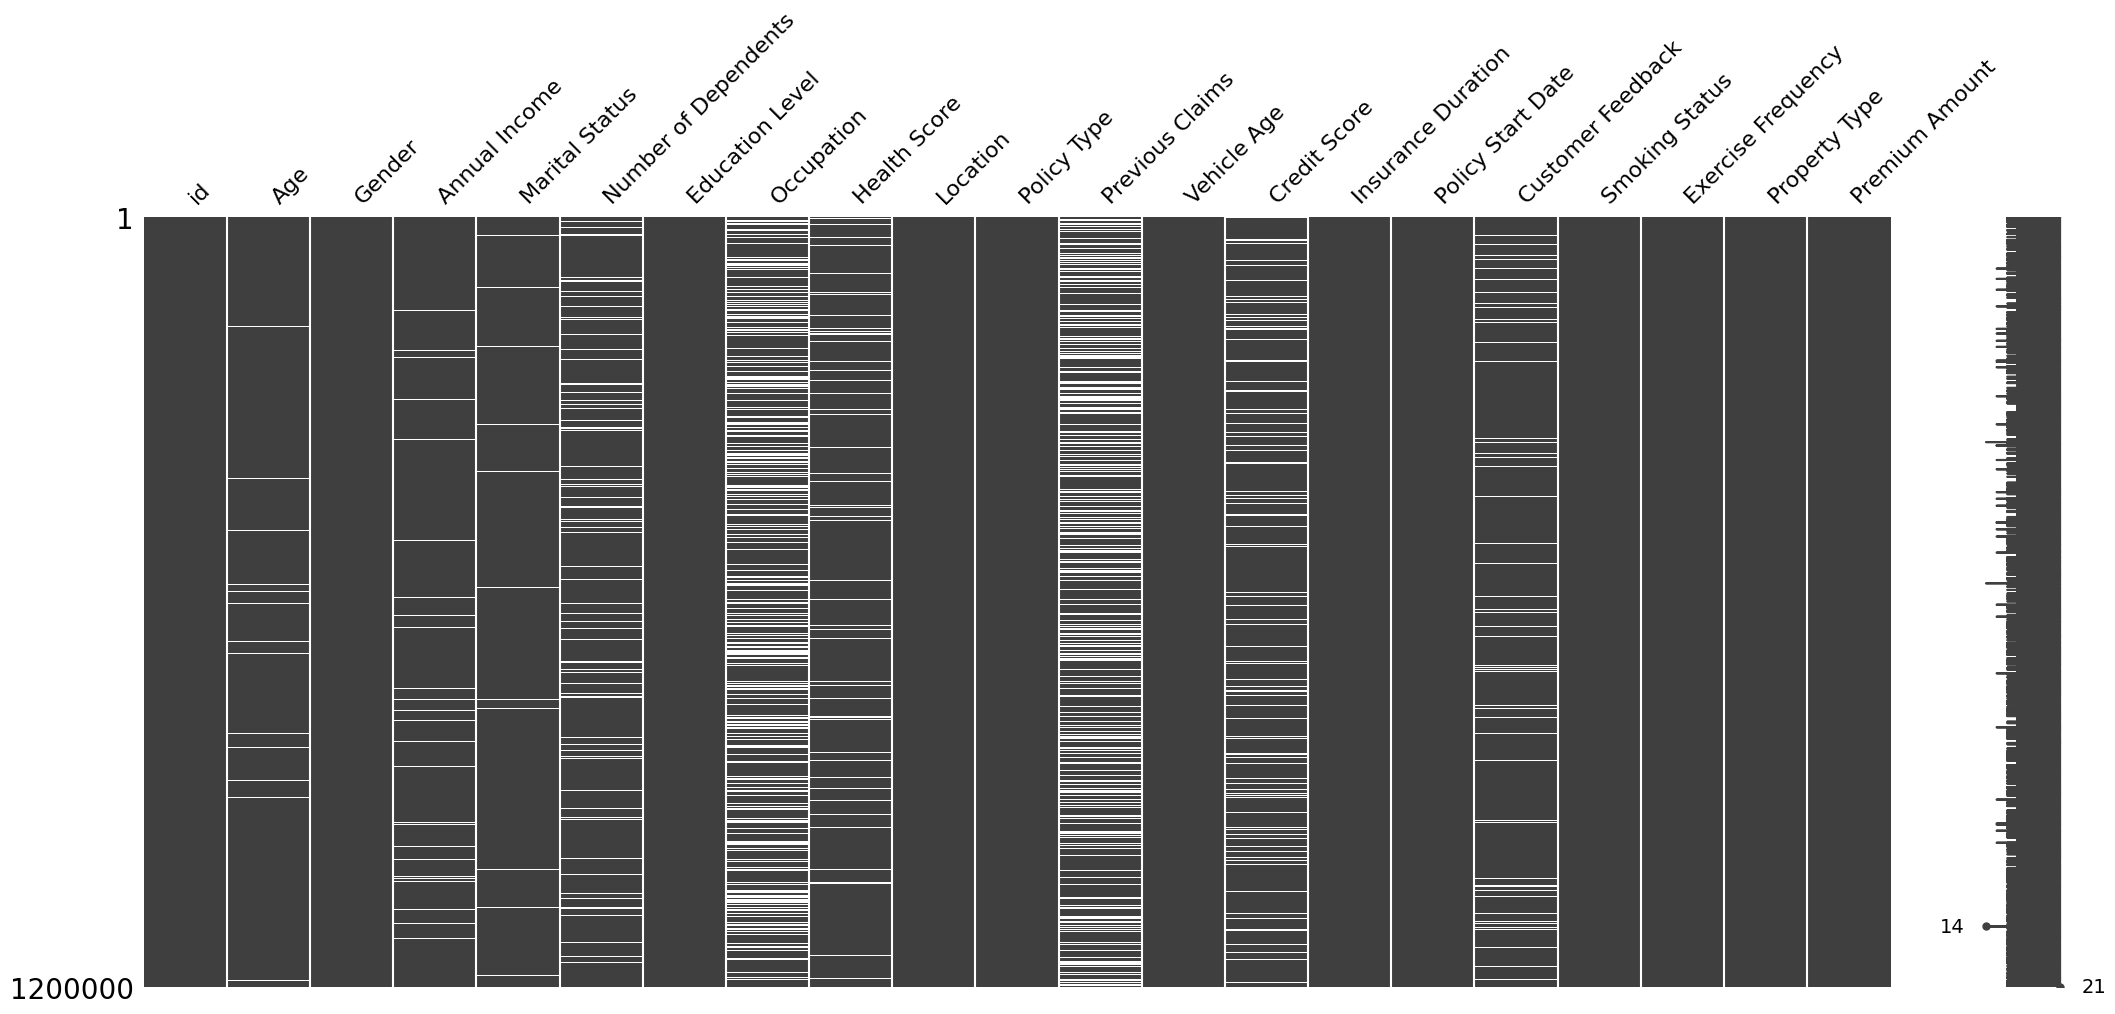

In [19]:
msno.matrix(train)
plt.show()

## Analysing numerical features using histograms, box plots, and density plots

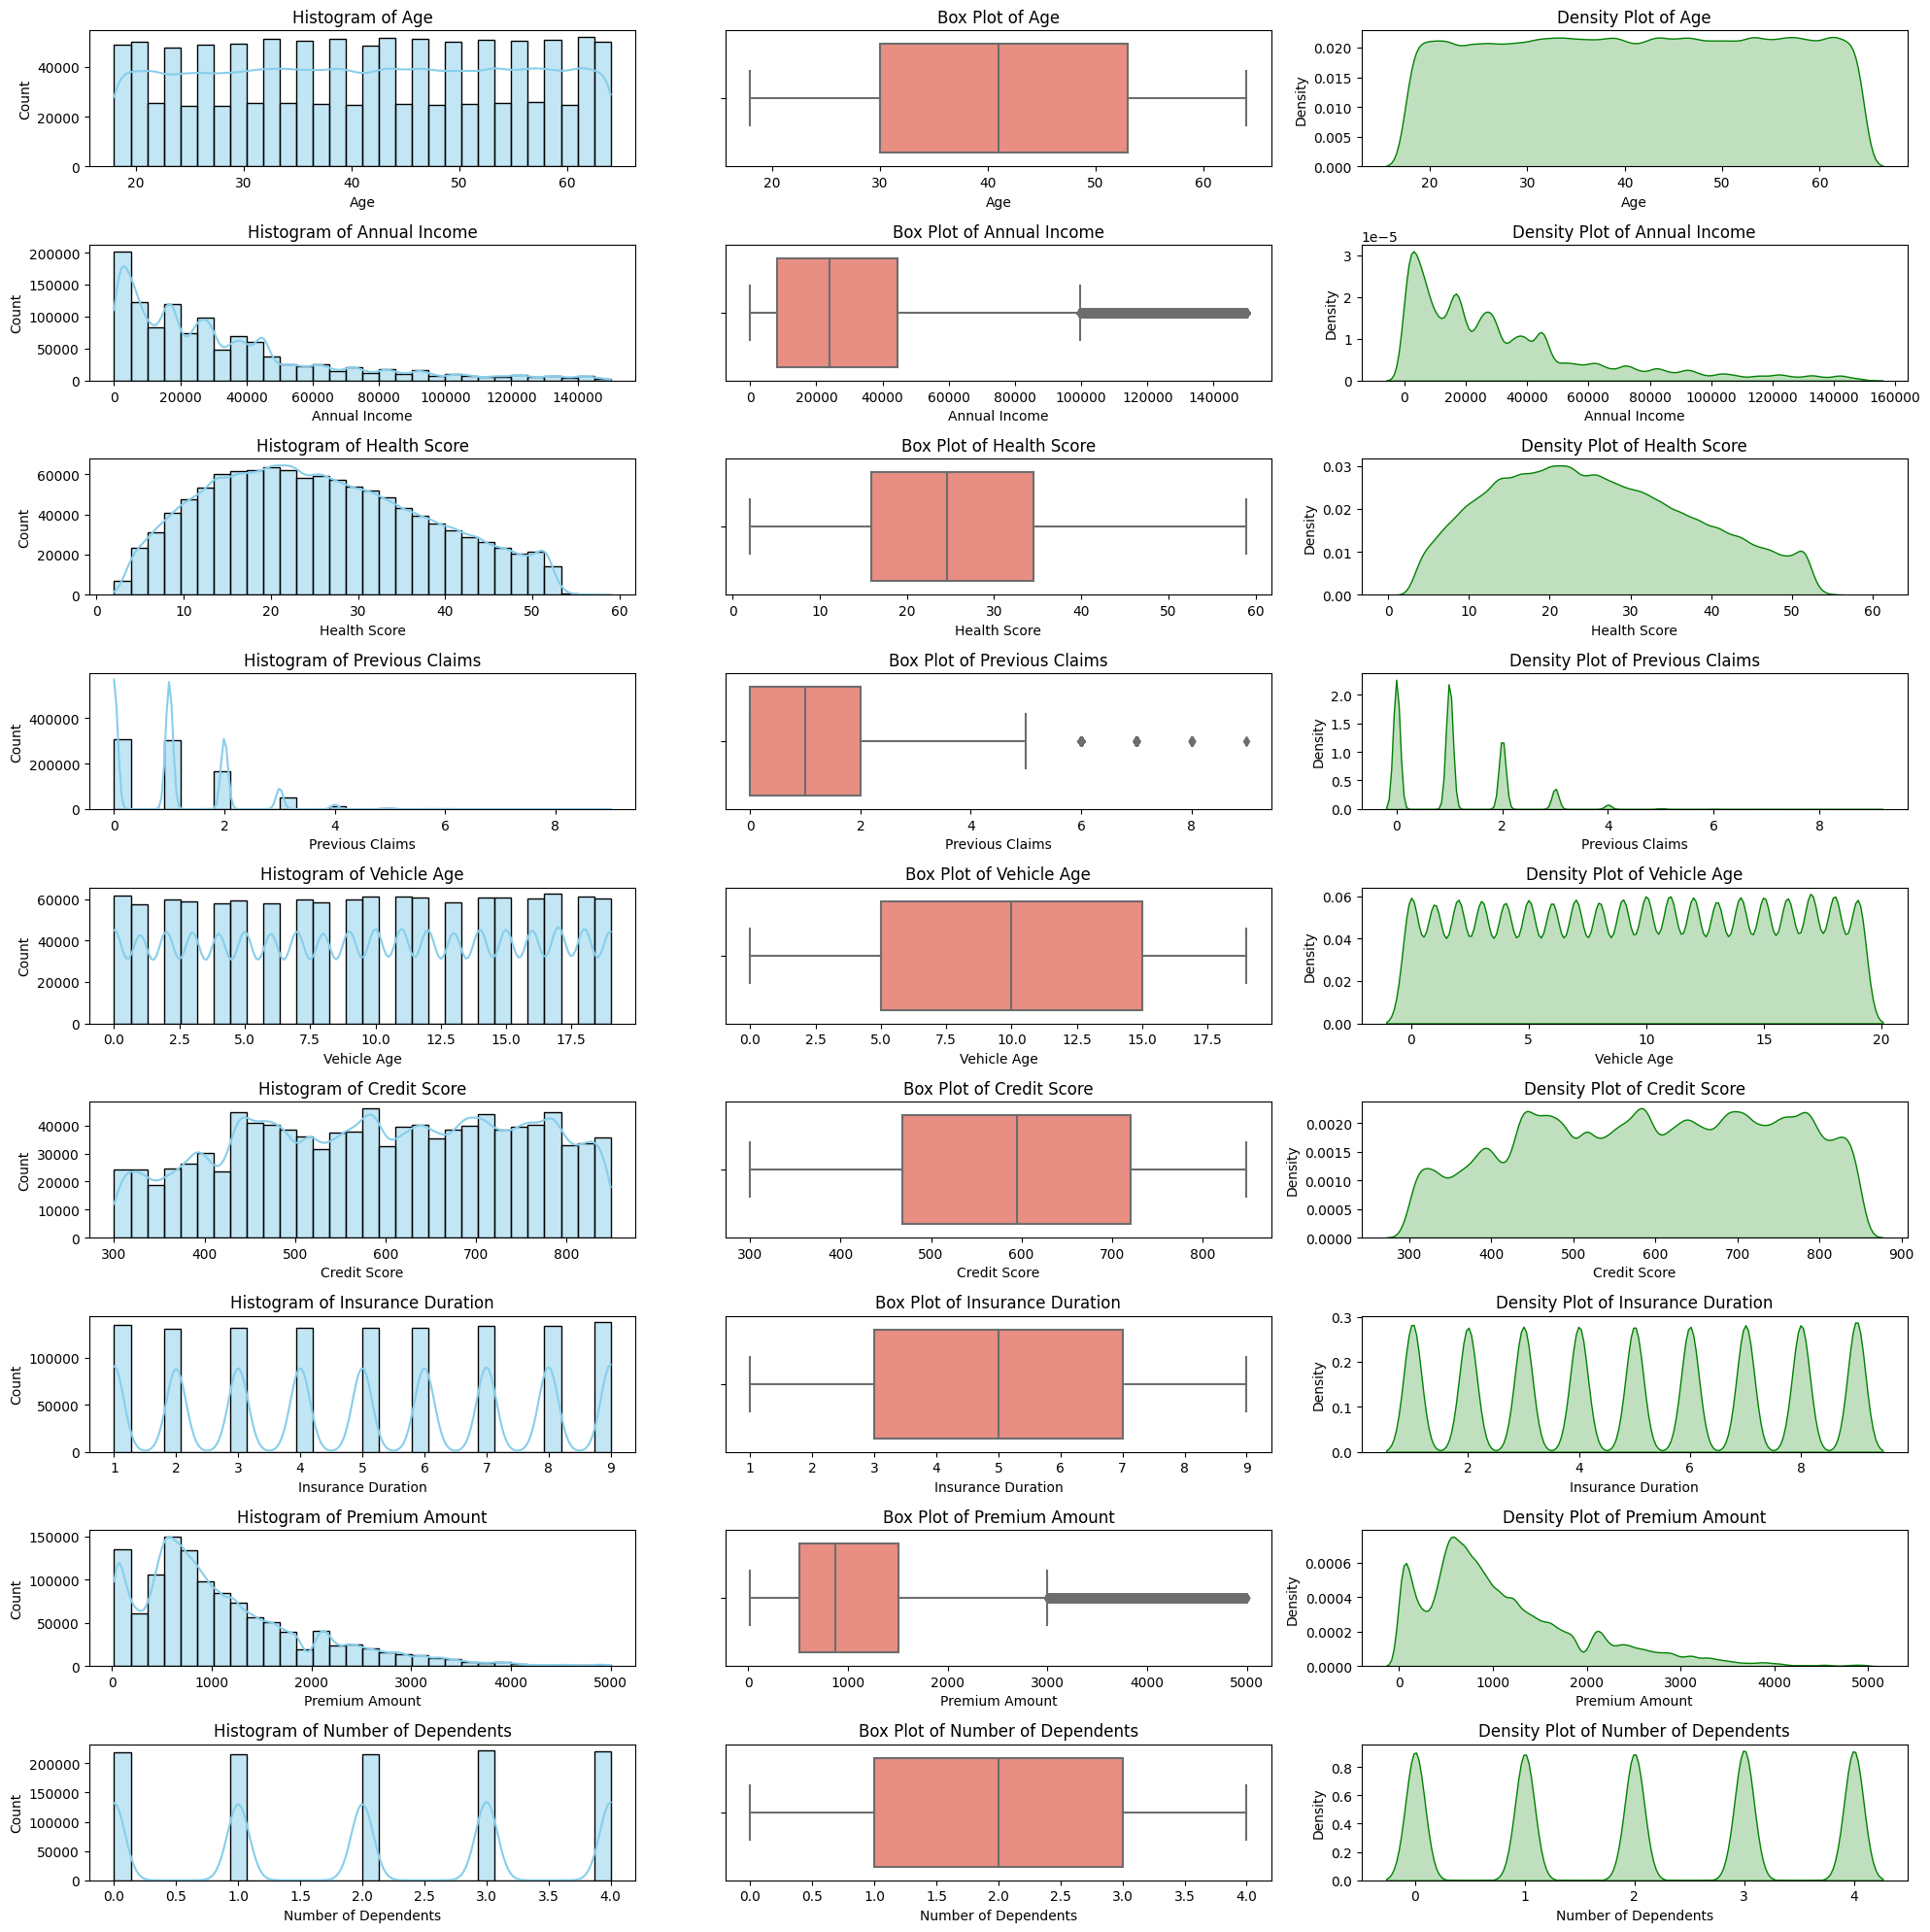

In [20]:
numerical_features = [
    'Age', 'Annual Income', 'Health Score', 'Previous Claims', 
    'Vehicle Age', 'Credit Score', 'Insurance Duration', 'Premium Amount',  'Number of Dependents'
]

plt.figure(figsize=(20, 20))
for i, feature in enumerate(numerical_features):
    plt.subplot(len(numerical_features), 3, i * 3 + 1)
    sns.histplot(train[feature], kde=True, bins=30, color='skyblue')
    plt.title(f'Histogram of {feature}')
    
    plt.subplot(len(numerical_features), 3, i * 3 + 2)
    sns.boxplot(x=train[feature], color='salmon')
    plt.title(f'Box Plot of {feature}')
    
    plt.subplot(len(numerical_features), 3, i * 3 + 3)
    sns.kdeplot(train[feature], fill=True, color='green')
    plt.title(f'Density Plot of {feature}')
    
plt.tight_layout()
plt.show()

## Analysing distribution in categorical features using bar plots

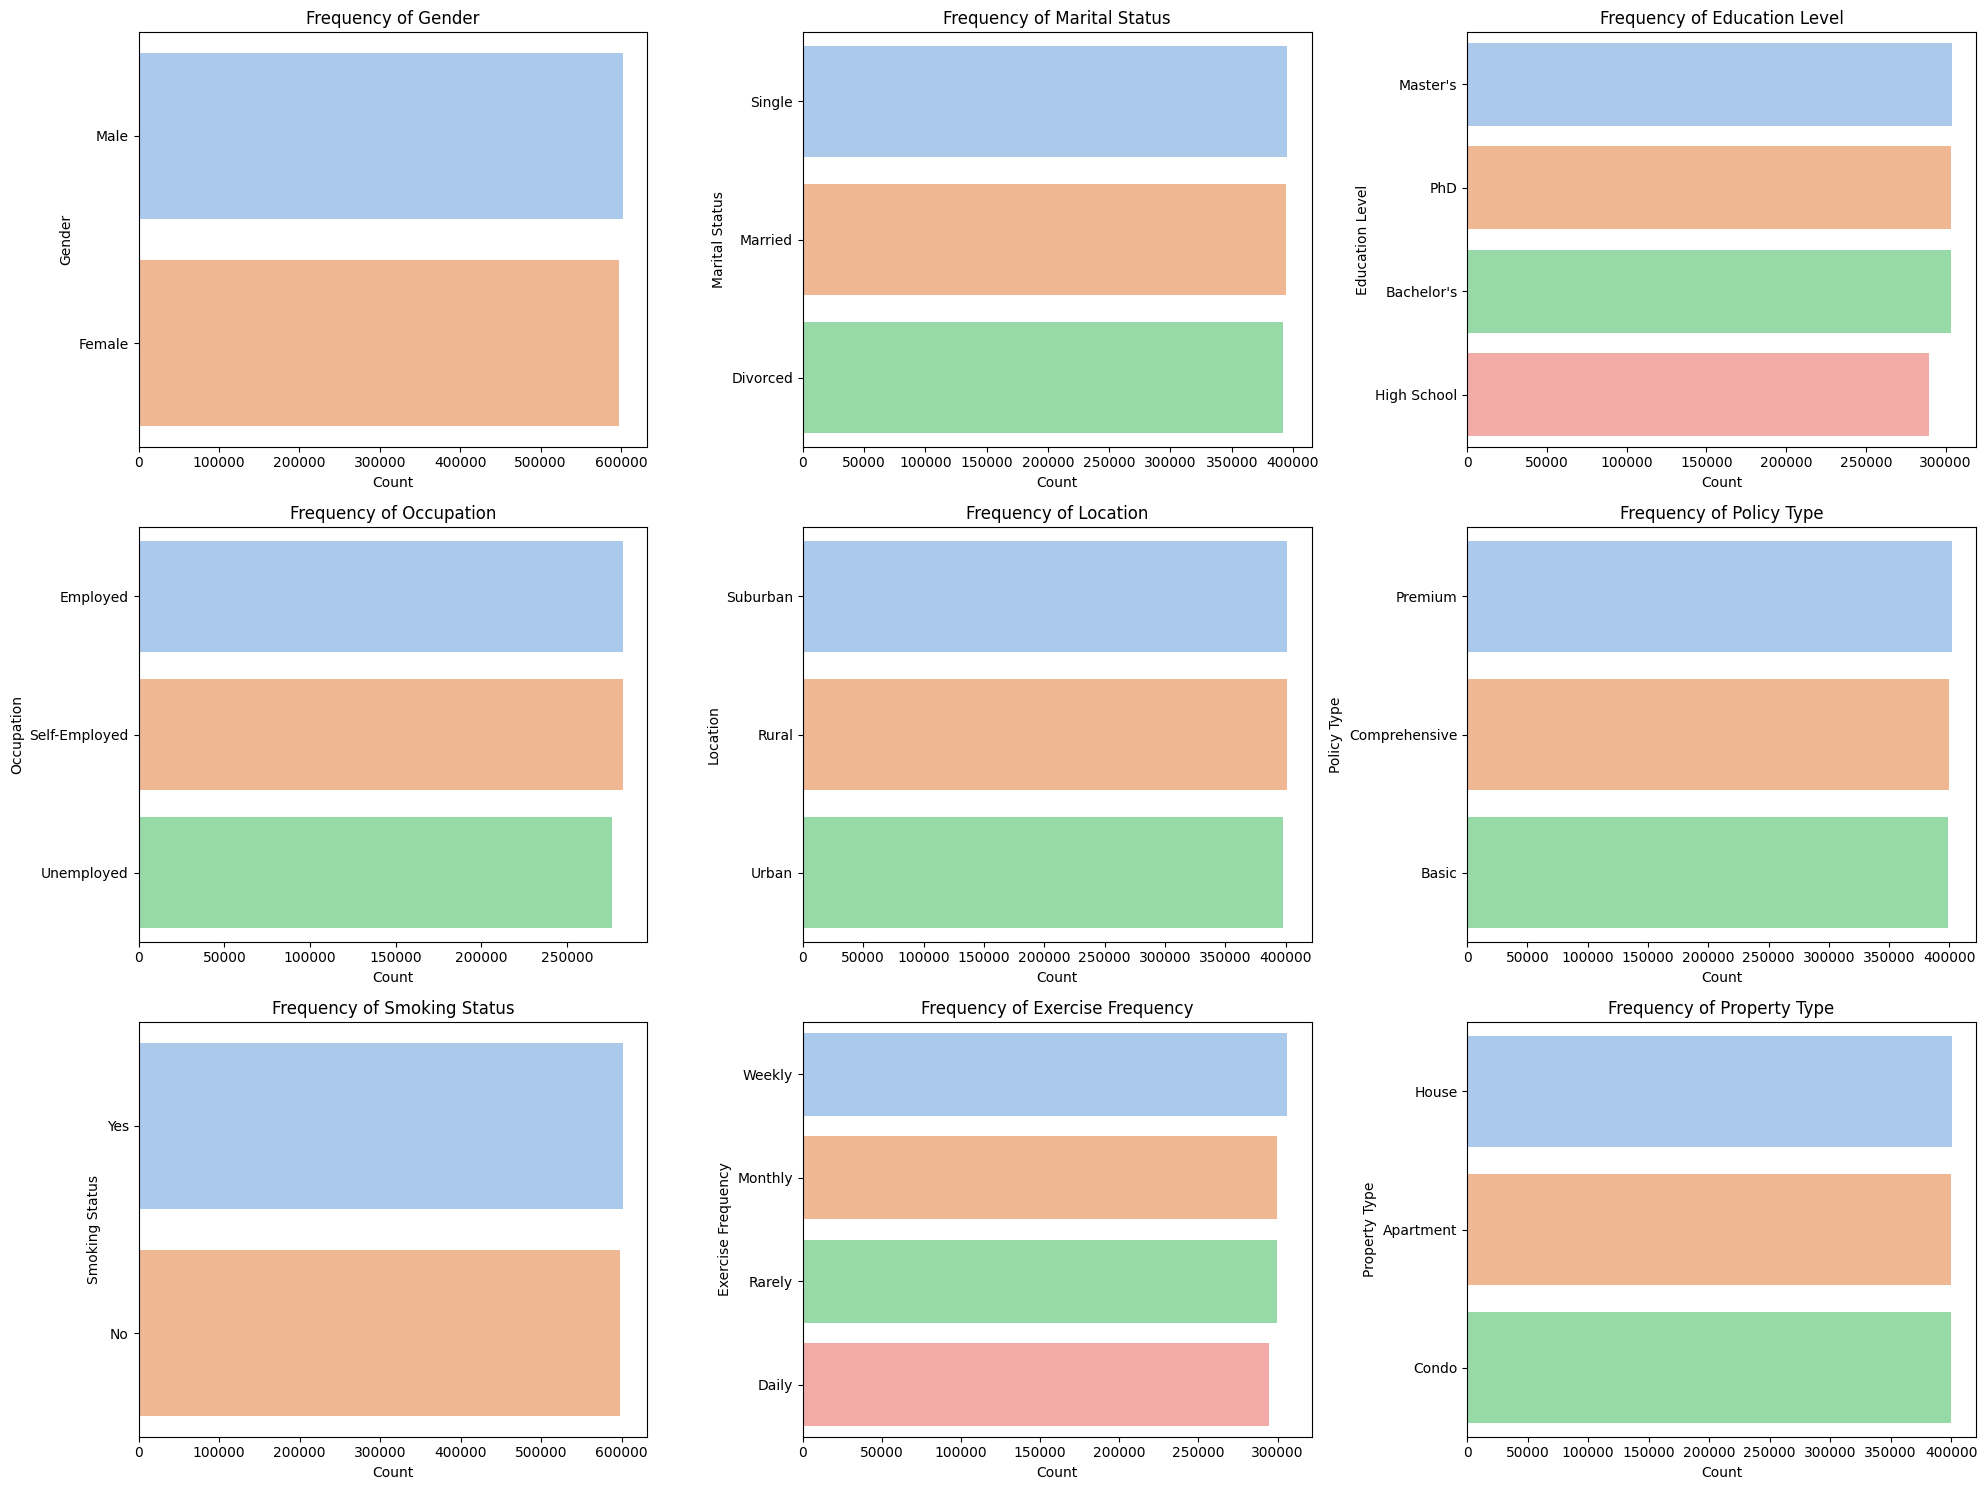

In [21]:
categorical_features = ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 
                        'Policy Type', 'Smoking Status', 'Exercise Frequency', 'Property Type']

plt.figure(figsize=(20, 15))
for i, feature in enumerate(categorical_features):
    plt.subplot((len(categorical_features) + 2) // 3, 3, i + 1)
    sns.countplot(y=train[feature], order=train[feature].value_counts().index, palette='pastel')
    plt.title(f'Frequency of {feature}')
    plt.xlabel('Count')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

## Exploring Correlation

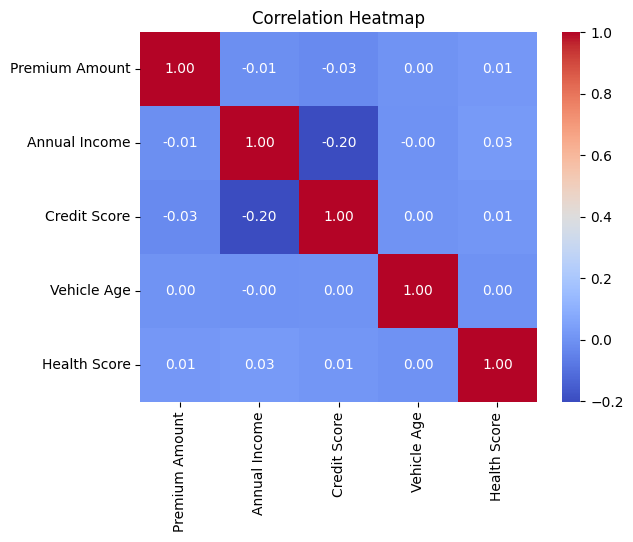

In [22]:
corr_matrix = train[['Premium Amount', 'Annual Income', 'Credit Score', 'Vehicle Age', 'Health Score']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

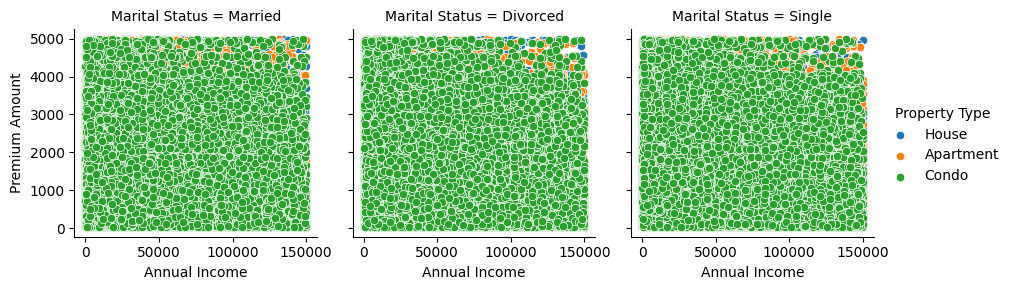

In [23]:
g = sns.FacetGrid(train, col='Marital Status', hue='Property Type')
g.map(sns.scatterplot, 'Annual Income', 'Premium Amount')
g.add_legend()
plt.show()

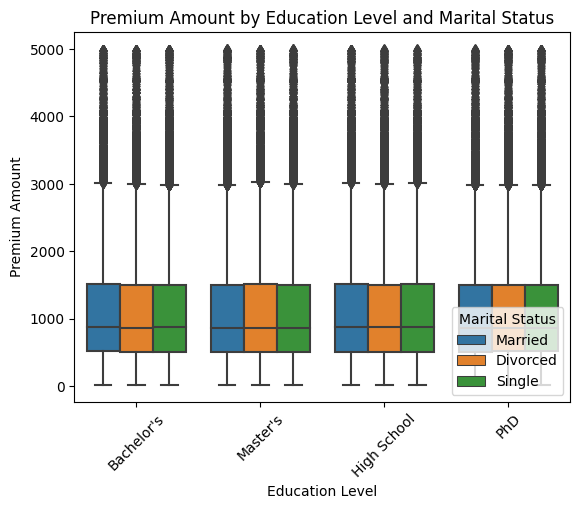

In [24]:
sns.boxplot(train, x='Education Level', y='Premium Amount', hue='Marital Status')
plt.title('Premium Amount by Education Level and Marital Status')
plt.xticks(rotation=45)
plt.show()

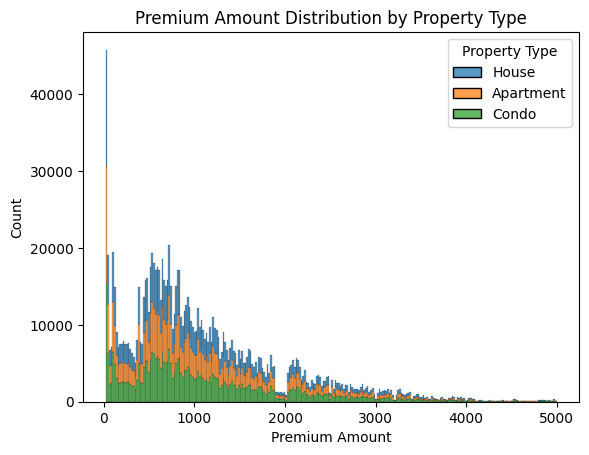

In [25]:
sns.histplot(train, x='Premium Amount', hue='Property Type', multiple='stack')
plt.title('Premium Amount Distribution by Property Type')
plt.show()

## Finding multicollinearity among numerical features

In [26]:
numerical_features = [
    'Age', 'Annual Income', 'Health Score', 'Previous Claims', 
    'Vehicle Age', 'Credit Score', 'Insurance Duration', 'Premium Amount',  'Number of Dependents'
]

temp_df= train[numerical_features].dropna()
vif_data = pd.DataFrame()
vif_data['Feature'] = temp_df.columns
vif_data['VIF'] = [variance_inflation_factor(temp_df.values, i) for i in range(temp_df.shape[1])]
print(vif_data)

                Feature        VIF
0                   Age   8.120992
1         Annual Income   1.982681
2          Health Score   4.930564
3       Previous Claims   2.025718
4           Vehicle Age   3.506828
5          Credit Score  10.564641
6    Insurance Duration   4.347950
7        Premium Amount   2.553996
8  Number of Dependents   2.886390


# Data Processing

## Imputing missing values

In [4]:
numerical_cols = ['Previous Claims', 'Health Score', 'Credit Score', 'Annual Income', 
                  'Age', 'Vehicle Age', 'Insurance Duration', 'Number of Dependents']

categorical_cols = ['Marital Status', 'Customer Feedback', 'Occupation']

def impute_values(df, numerical_cols, categorical_cols):
    num_imputer = SimpleImputer(strategy='median') 
    cat_imputer = SimpleImputer(strategy='constant', fill_value='Unknown') 

    df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])
    df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

    return df

train = impute_values(train, numerical_cols, categorical_cols)
test = impute_values(test, numerical_cols, categorical_cols)

## Feature Engineering

In [5]:
def date(df):
    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
    df['Year'] = df['Policy Start Date'].dt.year
    df['Day'] = df['Policy Start Date'].dt.day
    df['Month'] = df['Policy Start Date'].dt.month
    df['Month_name'] = df['Policy Start Date'].dt.month_name()
    df['Day_of_week'] = df['Policy Start Date'].dt.day_name()
    df['Week'] = df['Policy Start Date'].dt.isocalendar().week
    df['Year_sin'] = np.sin(2 * np.pi * df['Year'])
    df['Year_cos'] = np.cos(2 * np.pi * df['Year'])
    min_year = df['Year'].min()
    max_year = df['Year'].max()
    df['Year_sin'] = np.sin(2 * np.pi * (df['Year'] - min_year) / (max_year - min_year))
    df['Year_cos'] = np.cos(2 * np.pi * (df['Year'] - min_year) / (max_year - min_year))
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12) 
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)  
    df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)
    df['Group']=(df['Year']-2020)*48+df['Month']*4+df['Day']//7
    
    df.drop('Policy Start Date', axis=1, inplace=True)

    return df

train = date(train)
test = date(test)

## Encoding categorical values

In [6]:
categorical_cols = ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 
                    'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type', 'Month_name', 'Day_of_week']

def encode_values(df, categorical_cols):
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_data = encoder.fit_transform(df[categorical_cols])
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols), index=df.index)
    
    df = df.drop(columns=categorical_cols)
    df = pd.concat([df, encoded_df], axis=1)
    return df

train = encode_values(train, categorical_cols)
test = encode_values(test, categorical_cols)

In [7]:
missing_summary = train.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_summary / len(train)) * 100

missing_data = pd.DataFrame({'Missing Values': missing_summary, 
                             'Percentage (%)': missing_percentage})
print(missing_data[missing_data['Missing Values'] > 0])
print("-"*70)
missing_summary = test.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_summary / len(train)) * 100

missing_data = pd.DataFrame({'Missing Values': missing_summary, 
                             'Percentage (%)': missing_percentage})
print(missing_data[missing_data['Missing Values'] > 0])

Empty DataFrame
Columns: [Missing Values, Percentage (%)]
Index: []
----------------------------------------------------------------------
Empty DataFrame
Columns: [Missing Values, Percentage (%)]
Index: []


# Model Training (LightGBM + Optuna)

In [8]:
X = train.drop(columns = ['id', 'Premium Amount'])
y = train['Premium Amount']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

def root_mean_squared_log_error(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def objective(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "num_leaves": trial.suggest_int("num_leaves", 200, 512),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 1e-1),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 5, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "max_depth": trial.suggest_int("max_depth", -1, 16),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-4, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-4, 10.0),
        "feature_pre_filter": False,
       # "device_type": "gpu",
        "seed": 42
    }

    rmsle_scores = []

    for train_idx, val_idx in kf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

        model = lgb.train(params, train_data,
                          num_boost_round=1000,
                          valid_sets=[val_data],
                          callbacks=[lgb.early_stopping(stopping_rounds=10)])

        y_pred = model.predict(X_val, num_iteration=model.best_iteration)
        rmsle = root_mean_squared_log_error(y_val, np.maximum(y_pred, 0))
        rmsle_scores.append(rmsle)

    return np.mean(rmsle_scores)

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=10)

print("Best params:", study.best_params)
print("Best RMSLE:", study.best_value)

[I 2024-12-06 06:09:56,373] A new study created in memory with name: no-name-995482fe-12bd-4e7c-b66e-4281ede01098


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.196129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1365
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1102.505529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-06 06:14:34,013] Trial 0 finished with value: 1.139903198353021 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 329, 'learning_rate': 0.022206541173578277, 'feature_fraction': 0.6541080773372, 'bagging_fraction': 0.8795036685293658, 'bagging_freq': 7, 'min_data_in_leaf': 65, 'max_depth': 7, 'lambda_l1': 0.00022508274895139877, 'lambda_l2': 0.0012360984652205998}. Best is trial 0 with value: 1.139903198353021.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1365
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1102.505529
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 864.258
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_

[I 2024-12-06 06:17:26,629] Trial 1 finished with value: 1.17079298871622 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 225, 'learning_rate': 0.00010260702355593004, 'feature_fraction': 0.797999764567715, 'bagging_fraction': 0.7758538269946654, 'bagging_freq': 8, 'min_data_in_leaf': 64, 'max_depth': 1, 'lambda_l1': 0.029243658192045593, 'lambda_l2': 0.001055776875079823}. Best is trial 0 with value: 1.139903198353021.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1365
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1102.505529


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-06 07:17:40,981] Trial 2 finished with value: 1.1439117611829428 and parameters: {'boosting_type': 'dart', 'num_leaves': 239, 'learning_rate': 0.08248487140983672, 'feature_fraction': 0.6241394862337254, 'bagging_fraction': 0.8702500910961705, 'bagging_freq': 5, 'min_data_in_leaf': 97, 'max_depth': 4, 'lambda_l1': 4.285530353135439, 'lambda_l2': 0.27959105654390287}. Best is trial 0 with value: 1.139903198353021.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.258074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1365
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1102.505529
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-06 07:25:06,214] Trial 3 finished with value: 1.1686196763652135 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 322, 'learning_rate': 0.0003128405512225162, 'feature_fraction': 0.6921416719145079, 'bagging_fraction': 0.8056021047745983, 'bagging_freq': 8, 'min_data_in_leaf': 76, 'max_depth': 5, 'lambda_l1': 0.0155894628400207, 'lambda_l2': 0.003602178003279893}. Best is trial 0 with value: 1.139903198353021.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1365
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1102.505529
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 847.777
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.265851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1367
[LightGBM] [In

[I 2024-12-06 07:41:15,652] Trial 4 finished with value: 1.1572156900363826 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 228, 'learning_rate': 0.0005638628508712409, 'feature_fraction': 0.9028175045738411, 'bagging_fraction': 0.8127858829558272, 'bagging_freq': 10, 'min_data_in_leaf': 62, 'max_depth': 15, 'lambda_l1': 0.49229371549092543, 'lambda_l2': 6.491161767549054}. Best is trial 0 with value: 1.139903198353021.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1365
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1102.505529
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-12-06 07:49:27,477] Trial 5 finished with value: 1.1693798182256478 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 245, 'learning_rate': 0.00012563466644828361, 'feature_fraction': 0.9452850945513963, 'bagging_fraction': 0.8110529064796048, 'bagging_freq': 5, 'min_data_in_leaf': 98, 'max_depth': 5, 'lambda_l1': 0.0001081030538249916, 'lambda_l2': 0.032512626478024026}. Best is trial 0 with value: 1.139903198353021.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1365
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1102.505529
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2024-12-06 07:57:25,378] Trial 6 finished with value: 1.1423508700842362 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 391, 'learning_rate': 0.016267648533464255, 'feature_fraction': 0.6275619427670456, 'bagging_fraction': 0.9759093827948534, 'bagging_freq': 10, 'min_data_in_leaf': 40, 'max_depth': 6, 'lambda_l1': 0.05173495680530206, 'lambda_l2': 0.0024037686000467615}. Best is trial 0 with value: 1.139903198353021.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1365
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1102.505529


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-06 10:40:26,065] Trial 7 finished with value: 1.117743682200609 and parameters: {'boosting_type': 'dart', 'num_leaves': 412, 'learning_rate': 0.03126241470432303, 'feature_fraction': 0.7996099605089092, 'bagging_fraction': 0.7058878091584415, 'bagging_freq': 11, 'min_data_in_leaf': 56, 'max_depth': 12, 'lambda_l1': 0.0001121134674012727, 'lambda_l2': 9.183271801917314}. Best is trial 7 with value: 1.117743682200609.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1365
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1102.505529
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[396]	valid_0's rmse: 835.755
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`

[I 2024-12-06 10:50:10,392] Trial 8 finished with value: 1.1329395219864726 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 437, 'learning_rate': 0.0058381862703783755, 'feature_fraction': 0.9842164175816196, 'bagging_fraction': 0.7029945529181443, 'bagging_freq': 11, 'min_data_in_leaf': 62, 'max_depth': 13, 'lambda_l1': 0.008121273108395343, 'lambda_l2': 0.5464184438950392}. Best is trial 7 with value: 1.117743682200609.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.207904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1365
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1102.505529


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1367
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1102.823247


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1367
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1101.344157


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1365
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1103.143324


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1366
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1102.907851


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
[I 2024-12-06 13:17:20,122] Trial 9 finished with value: 1.1126139856670616 and parameters: {'boosting_type': 'dart', 'num_leaves': 401, 'learning_rate': 0.02531450045337655, 'feature_fraction': 0.9124376334916204, 'bagging_fraction': 0.8857663142473978, 'bagging_freq': 6, 'min_data_in_leaf': 76, 'max_depth': 0, 'lambda_l1': 0.021079061732485003, 'lambda_l2': 0.5190044232164691}. Best is trial 9 with value: 1.1126139856670616.


Best params: {'boosting_type': 'dart', 'num_leaves': 401, 'learning_rate': 0.02531450045337655, 'feature_fraction': 0.9124376334916204, 'bagging_fraction': 0.8857663142473978, 'bagging_freq': 6, 'min_data_in_leaf': 76, 'max_depth': 0, 'lambda_l1': 0.021079061732485003, 'lambda_l2': 0.5190044232164691}
Best RMSLE: 1.1126139856670616


# Training Model with with best

In [12]:
best_params = study.best_params

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

model = lgb.train(best_params, train_data,  
                valid_sets=[val_data],
                callbacks=[lgb.early_stopping(stopping_rounds=10)])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1367
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 59
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1102.505529


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


In [15]:
test_id = test.copy()
test.drop('id', axis=1, inplace=True, errors='ignore')
test_predictions = model.predict(test, num_iteration=model.best_iteration)
submission = pd.DataFrame({'id': test_id['id'], 'Premium Amount': test_predictions})
submission.to_csv("submission.csv", index=False)
print("Submission saved to 'submission.csv'")

In [14]:
submission.head()

,id,Premium Amount
0,1200000,887.471759
1,1200001,774.888156
2,1200002,775.050854
3,1200003,770.414993
4,1200004,746.368407
